Network models chapther 12 

Functions

In [367]:
import numpy as np
import math
import networkx as nx
import matplotlib.pyplot as plt
from tqdm import trange
def CreatErdosRenyiGraph(n0,p=1,c=np.NaN,m=np.NaN,nEnd=np.NaN):
    pRew=p
    if ~np.isnan(c):
        p=0
    matrix=CreateDataToAdjencyGraph(n0,p,c=c,m=m,nEnd=nEnd)
    fig1, (ax1,ax2) = plt.subplots(1,2,figsize=(15,5))
    PlotAdjencyGraph(matrix,ax1)
    
    n=len(matrix)
    ax1.set_title(' n='+str(n)+' p='+str(p)+' c='+str(c))
    if np.isnan(c) and np.isnan(m):
        ax2.set_box_aspect(1)
        histArray=np.count_nonzero(matrix, axis=1)
        weights = np.ones_like(histArray) / len(histArray)

        mean=np.mean(histArray)
        std_dev=np.std(histArray)
        xBell = np.linspace(mean - 4 * std_dev, mean + 4 * std_dev, 1000)
        yBell = (1 / (np.sqrt(2 * np.pi) * std_dev)) * np.exp(-0.5 * ((xBell - mean) / std_dev) ** 2)

        binwidth=1
        ax2.hist(histArray,bins=np.arange(np.min(histArray), np.max(histArray) + binwidth),weights=weights,rwidth=0.9,align='left',label='Simulated distribution')
        ax2.plot(xBell,yBell,label="Gausian distribution")
        xRange=np.arange(int(np.min(histArray*0.9)), int(np.max(histArray)*1.1)+1, 1, dtype=int)
        yGeneric=[]
        for x in xRange:
            yGeneric.append(ProbGenericFunction(n,p,x))
        ax2.plot(xRange,yGeneric,label='Theoretical distribution')
        ax2.legend()
    elif np.isnan(m): 
        matrixRewire=CreateDataToAdjencyGraph(n0,p=pRew,c=c)
        #matrixRewire=RandomlyRewireConnections(matrix,pRew)
        G = nx.from_numpy_array(matrixRewire)
        ax2.set_box_aspect(1)
        nx.draw(G,pos=nx.circular_layout(G) ,with_labels=False, node_color='orange', node_size=int(100), font_weight='bold',ax=ax2)

        ax2.set_title(' n='+str(n)+' p='+str(pRew)+' c='+str(c))
    else: 
        ax1.set_title(' n0='+str(n0)+' m='+str(m)+' n='+str(n))
        D=np.count_nonzero(matrix,axis=0)
        D=np.sort(D)#[::-1]
        #D=np.cumsum(D)
        u=np.arange(1,n+1)/(n)
        ax2.loglog(np.flip(D),u,'o',label='Meassured')

        k=[D[0],D[-1]]    
        C1=m**2*(1/k[0])**(2)
        C2=m**2*(1/k[1])**(2)
        
        ax2.loglog(k,[C1,C2],'--',label='Prediction')
        ax2.set_xlabel('k')
        ax2.set_ylabel('C(k)')
        ax2.legend()
    
    plt.show()
def ProbGenericFunction(n,p,k):
    binomial=math.comb(n-1, k)
    return  binomial*(p**k)*(1-p)**(n-1-k)

def CreateDataToAdjencyGraph(n,p,c=np.NaN,m=np.NaN,nEnd=np.NaN):
    A=np.zeros((n,n))
    for i in range(n):
        for j in range(n):
            if np.isnan(c):
                if j>i:
                    r=np.random.random()
                    if r<=p:
                        A[i,j]=1
                        A[j,i]=1
            else: 
                if NormPerodic(i,j,c,n):
                    A[i,j]=1
                    A[j,i]=1
    if ~np.isnan(c):
        A=RandomlyRewireConnections(A,p)
    elif ~np.isnan(m):
        A=AddN0Nodes(A,m,nEnd)
                    
    return(A)


def NormPerodic(i,j,c,n):
    diff = abs(i - j)
    distance = min(diff, n - diff)  #perodic boundery 
    return 1 <= distance <= c/2
        
def RandomlyRewireConnections(A,p):
    n=len(A)
    for i in range(n):
        for j in range(n):
            if A[i,j]==1:
                if p>np.random.random():
                    posibleChoices = list(range(i)) + list(range(i+1, n))
                    jNew=np.random.choice(posibleChoices)
                    A[i,j]=0 
                    A[i,jNew]=1
                    A[j,i]=0 
                    A[jNew,i]=1
    return A


def AddN0Nodes(A,m,nEnd):
    n0=np.shape(A)[0]
    for i in trange (nEnd-n0):
        A=AddNodeAndConnectIt(A,m)
    return(A)

def AddNodeAndConnectIt(A,m):
    n=len(A)
    A=np.insert(A, n, 0, axis=0)
    A=np.insert(A, n, 0, axis=1)
    nConections=np.count_nonzero(A,axis=0)
    
    probConections= nConections/sum(nConections)
    i=np.random.choice(np.arange(n+1),m, replace=False,p=probConections)

    for oneI in i:
        A[n,oneI]=1
        A[oneI,n]=1
    return A



def PlotAvgLAndC(n,ps=np.NaN,c=np.NaN,m=np.NaN,nEnd=np.NaN):
    l=[]
    C=[]
    for p in ps:
        li,Ci=AvgLengthClusteringCoefficant(n,p,c=c,m=m,nEnd=nEnd)
        l.append(li)
        C.append(Ci)
    
    if ~np.isnan(c):
        C50=[]
        C1000=[]
        #cs=np.logspace(0.32,2.2,num=30,base=10)
        cs=np.arange(2,120,2)
        
        for ci in cs:
            li50,Ci50=AvgLengthClusteringCoefficant(50,0,c=ci)
            li1000,Ci1000=AvgLengthClusteringCoefficant(100,0,c=ci)
            C50.append(Ci50)
            C1000.append(Ci1000)


    fig1, (ax1,ax2) = plt.subplots(1,2,figsize=(15,5))
    ax1.set_xscale("log")
    ax1.plot(ps,l,'o',label="Meassurments")
    ax1.set_xlabel('p')
    ax1.set_ylabel('l')

    if np.isnan(c):
    
        p=np.arange(0.014,1, 0.001)
        y=0.57722
        lSmall=(np.log(n)-y)/np.log(p*(n-1))  +0.5
        lLarge=2-p
        ax1.plot(p,lSmall,label="Prediction for small p")
        ax1.plot(p,lLarge,label="Prediction for large p")

    else: 
        theoryMax=np.ones(len(ps))*(n/(2*c))
        theoryMin=np.ones(len(ps))*(np.log(n)/np.log(c))
        ax1.plot(ps,theoryMax,'--',color='k',label="Theory max")
        ax1.plot(ps,theoryMin,'--',color='k',label="Theory min")


        cList=np.arange(2,120,0.2)#   np.logspace(,2.1,num=30,base=10)
        theoryC=(3*(cList-2))/(4*(cList-1))



    ax1.legend()

    
    if np.isnan(c):
        ax2.plot(ps,C,'o',label="Messured C")
        ax2.plot(ps,ps,'--',color='k',label="p")
        ax2.set_xlabel('p')
        ax2.set_ylabel('C')
    else: 
        ax2.set_xscale("log")
        ax2.plot(cs,C1000,'o',label="n=1000",markersize=12) 
        ax2.plot(cs,C50,'o',label="n=50")
        ax2.set_xlabel('c')
        ax2.set_ylabel('C')
          
        ax2.plot(cList,theoryC,'--',color='k',label="Theory")
    ax2.legend()




def AvgLengthClusteringCoefficant(n,p,c=np.NaN,m=np.NaN,nEnd=np.NaN):
    A0=CreateDataToAdjencyGraph(n,p,c)
    C=CalculateClusteringCoefficients(A0)
    
    
    n_zeros = np.count_nonzero(A0!=0, axis=1)
    nNodesWitoutConnection =np.count_nonzero(n_zeros==0)
    #print(np.count_nonzero(n_zeros==0))

    if nNodesWitoutConnection==0:
        L=np.ones((n,n))*-1
        A=np.identity(n)
        t=1
        while np.sum((L==-1))>n :
            A=np.matmul(A,A0)
            for i in range (n):
                for j in range (n):
                    if A[i,j]!=0 and i!=j and L[i,j]==-1:
                        L[i,j]=t
                        L[j,i]=t
            t+=1
        return (CalculateAverageLengthOfL(L)),C
    else: 
        print("Every node do not have a connection")
        return np.NaN,C


def CalculateAverageLengthOfL(A):
    AOutDiag=A[~np.eye(A.shape[0],dtype=bool)].reshape(A.shape[0],-1)
    return np.mean((AOutDiag))


def CalculateClusteringCoefficients(A0):
    A3=np.linalg.matrix_power(A0, 3)
    closed3=np.sum(np.trace(A3))

    k=np.count_nonzero(A0,axis=0) #Mybe A3
    all3=np.sum(k*(k-1))

    C=closed3/all3 
    return(C)


                
def PlotAdjencyGraph(A,ax):
    G = nx.from_numpy_array(A)
    ax.set_box_aspect(1)
    nx.draw(G,pos=nx.circular_layout(G) ,with_labels=False, node_color='orange', node_size=int(100), font_weight='bold',ax=ax)


In [354]:
from tqdm import trange
#12.6 functions
def CreateDataToAdjencyGraphAlbert(n,p=1,c=np.NaN,m=np.NaN,nEnd=np.NaN):
    A=np.zeros((n,n))
    for i in range(n):
        for j in range(n):
            if np.isnan(c):
                if j>i:
                    r=np.random.random()
                    if r<=p:
                        A[i,j]=1
                        A[j,i]=1
            else: 
                if NormPerodic(i,j,c,n):
                    A[i,j]=1
                    A[j,i]=1
    if ~np.isnan(c):
        A=RandomlyRewireConnections(A,p)
    elif ~np.isnan(m):
        A,lList=AddN0NodesAlbert(A,m,nEnd)
                    
    return(A,lList)

def AddN0NodesAlbert(A,m,nEnd):
    n0=np.shape(A)[0]
    l=[]
    for i in trange (nEnd-n0):
        A=AddNodeAndConnectIt(A,m)
        li=AverageLength(A)
        l.append(li)
        
    return(A,l)



def ClusteringCoefficantAlbert(n,p=1,c=np.NaN,m=np.NaN,nEnd=np.NaN):
    A0=CreateDataToAdjencyGraph(n,p,c,m,nEnd)
    print("Calculating cluster coefficients...")
    C=CalculateClusteringCoefficients(A0)
    return(C)

def AverageLength(A0):
    n=len(A0)
    n_zeros = np.count_nonzero(A0!=0, axis=1)
    nNodesWitoutConnection =np.count_nonzero(n_zeros==0)
    #print(np.count_nonzero(n_zeros==0))

    if nNodesWitoutConnection==0:
        L=np.ones((n,n))*-1
        A=np.identity(n)
        t=1
        while np.sum((L==-1))>n :
            A=np.matmul(A,A0)
            for i in range (n):
                for j in range (n):
                    if A[i,j]!=0 and i!=j and L[i,j]==-1:
                        L[i,j]=t
                        L[j,i]=t
            t+=1
        return (CalculateAverageLengthOfL(L))
    else: 
        print("Every node do not have a connection")
        return np.NaN




12.1

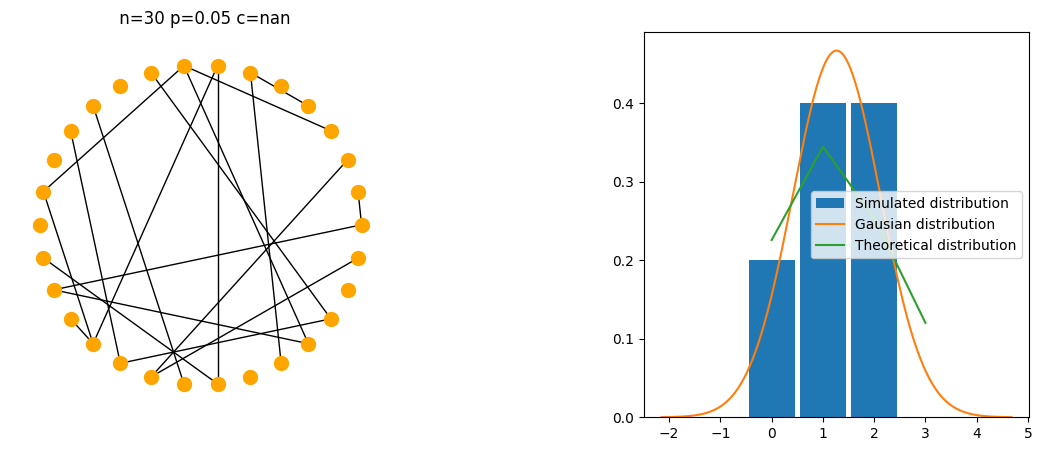

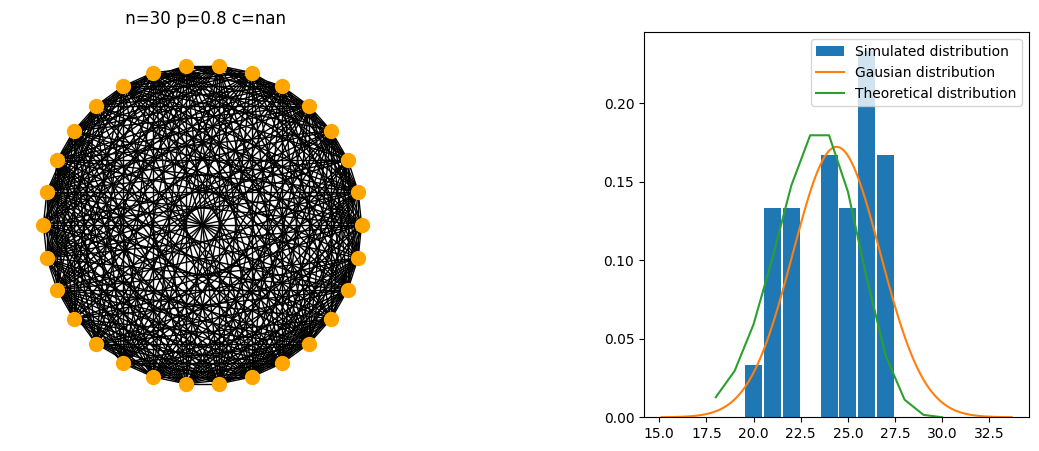

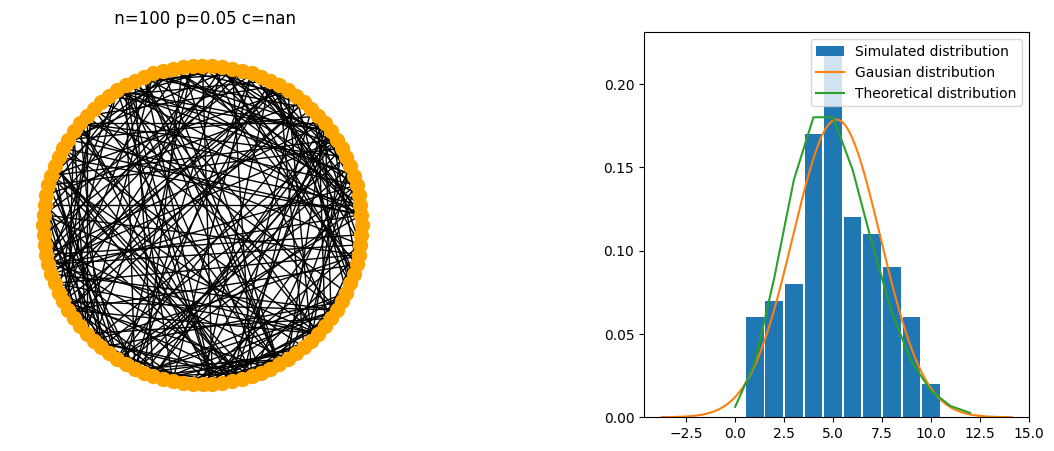

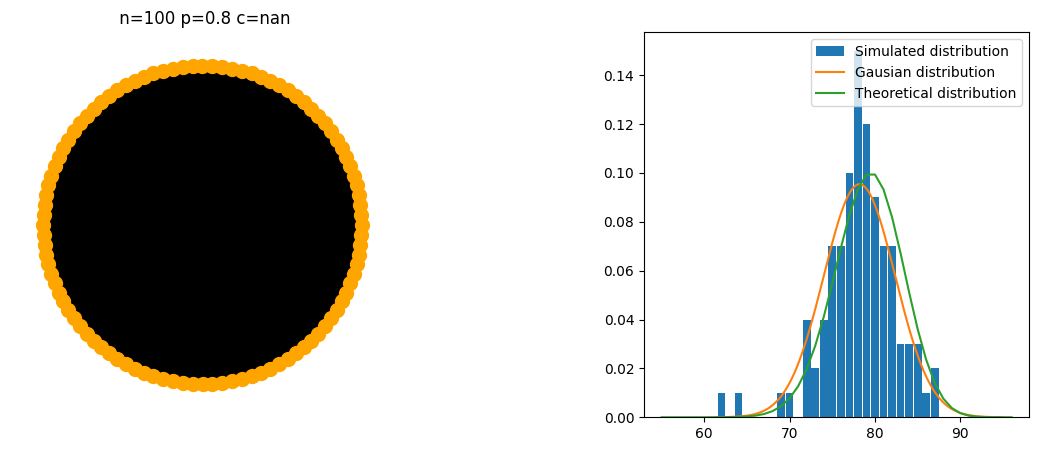

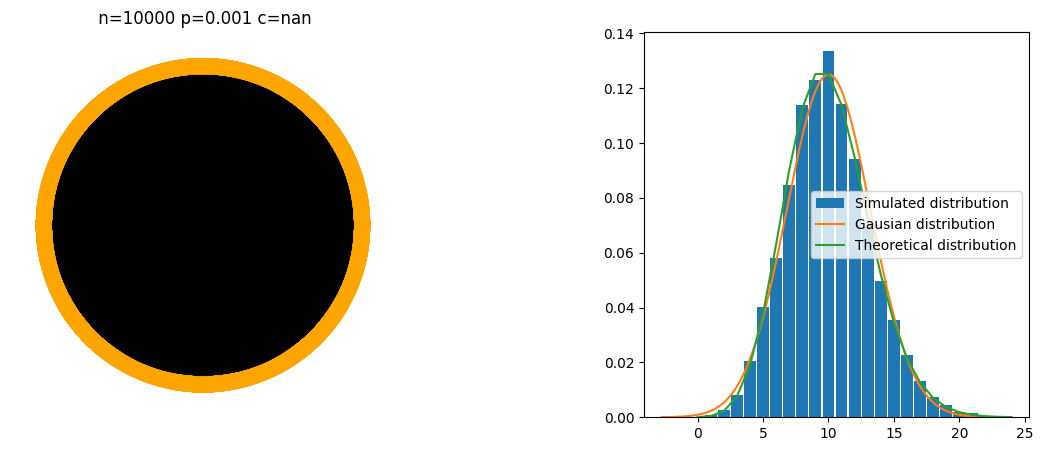

In [368]:
CreatErdosRenyiGraph(30,0.05)
CreatErdosRenyiGraph(30,0.8)
CreatErdosRenyiGraph(100,0.05)
CreatErdosRenyiGraph(100,0.8)
CreatErdosRenyiGraph(10000,0.001)

12.2 The Watts–Strogatz small-world model

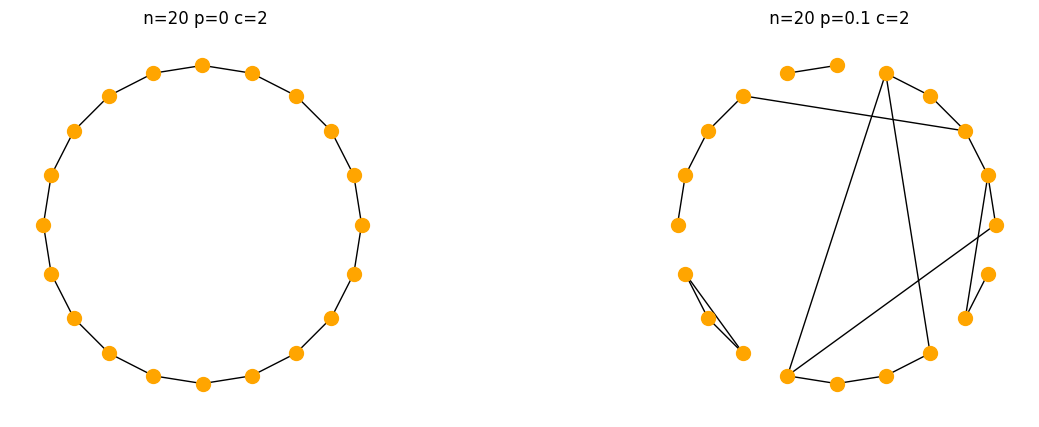

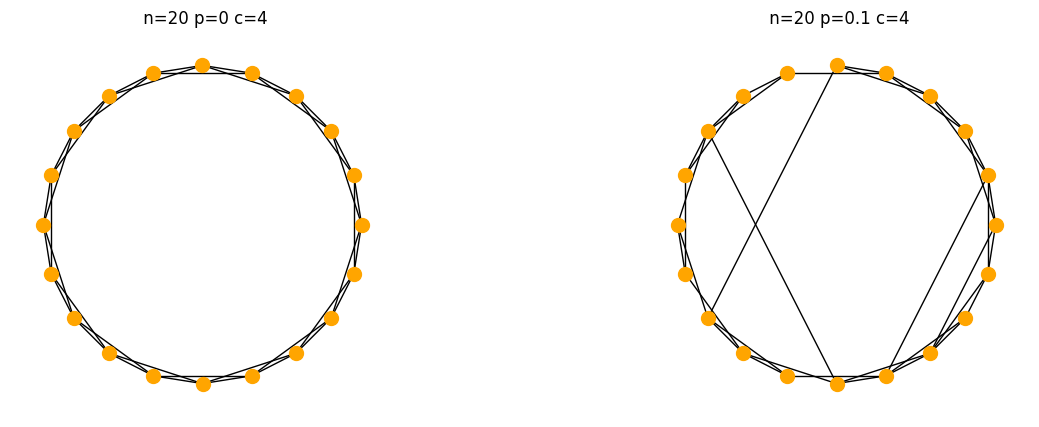

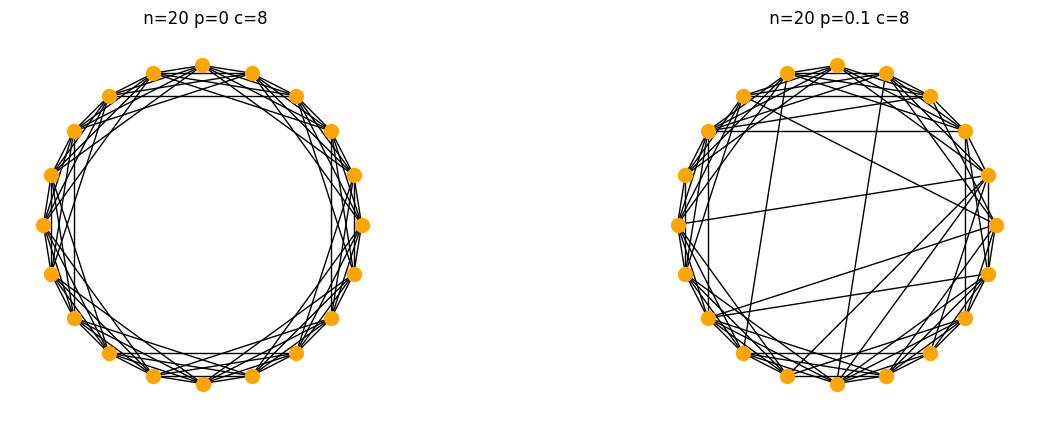

In [323]:
CreatErdosRenyiGraph(20,0.1,c=2)
CreatErdosRenyiGraph(20,0.1,c=4)
CreatErdosRenyiGraph(20,0.1,c=8)

12.3

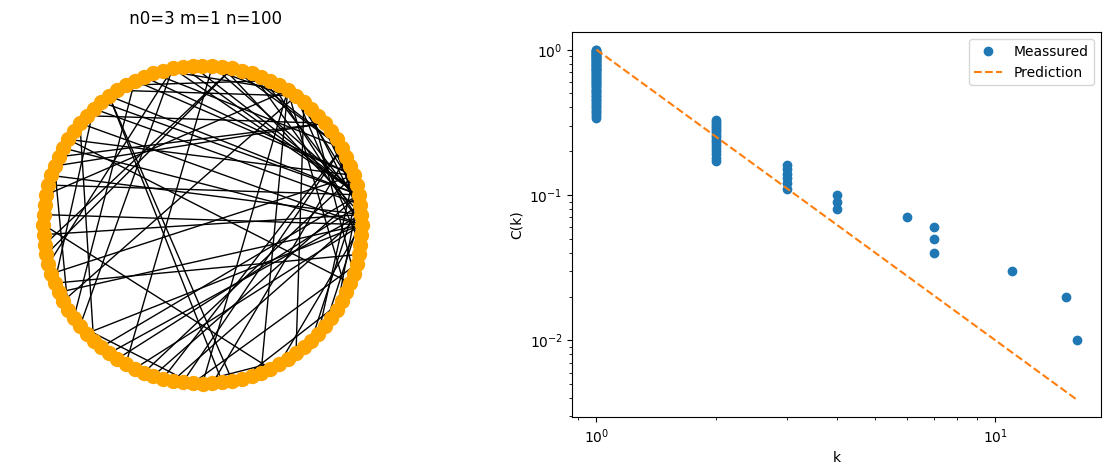

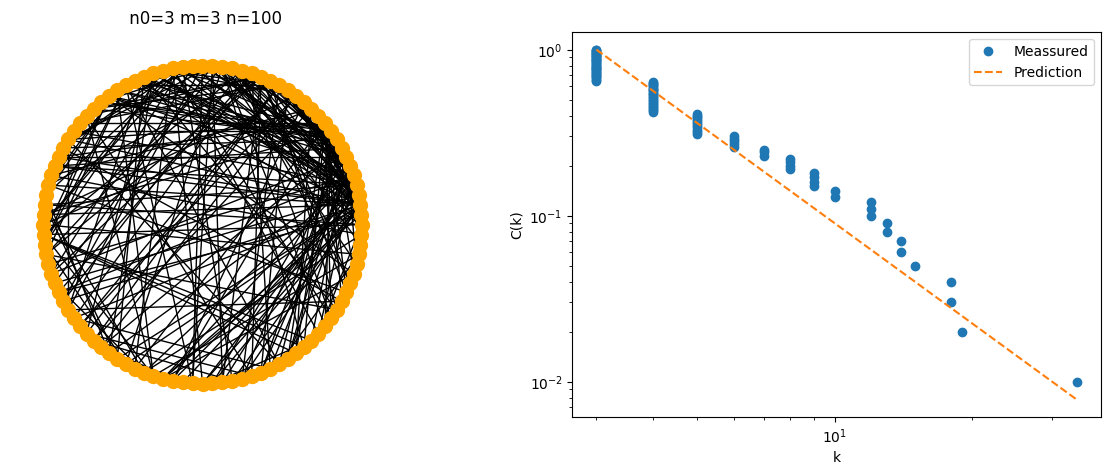

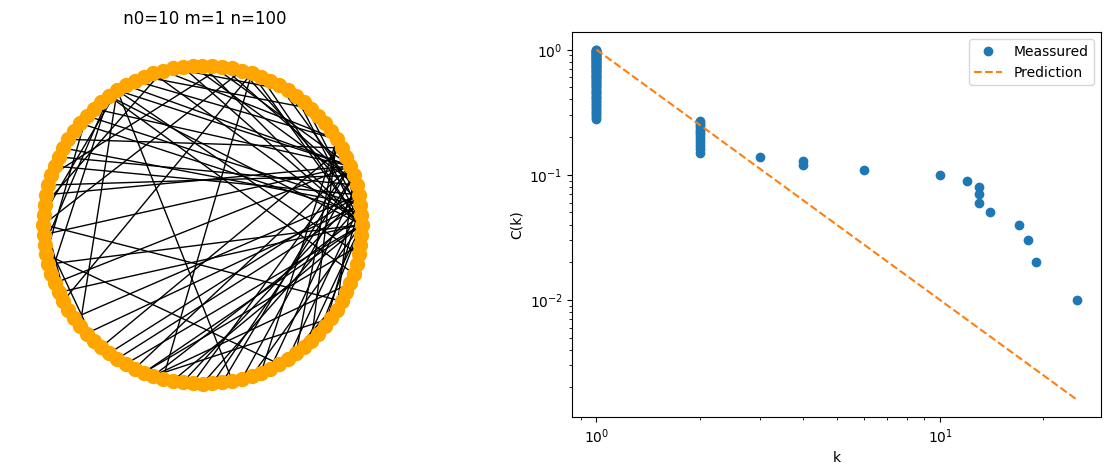

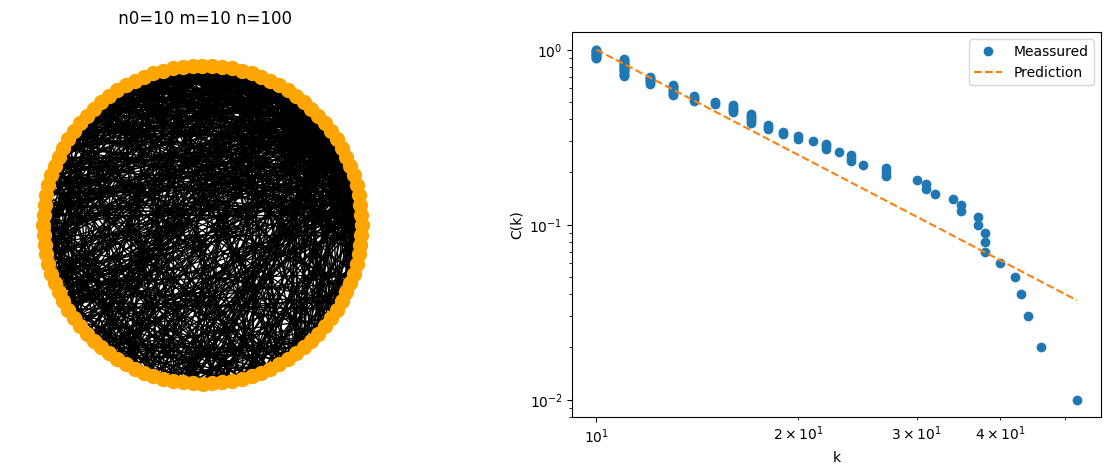

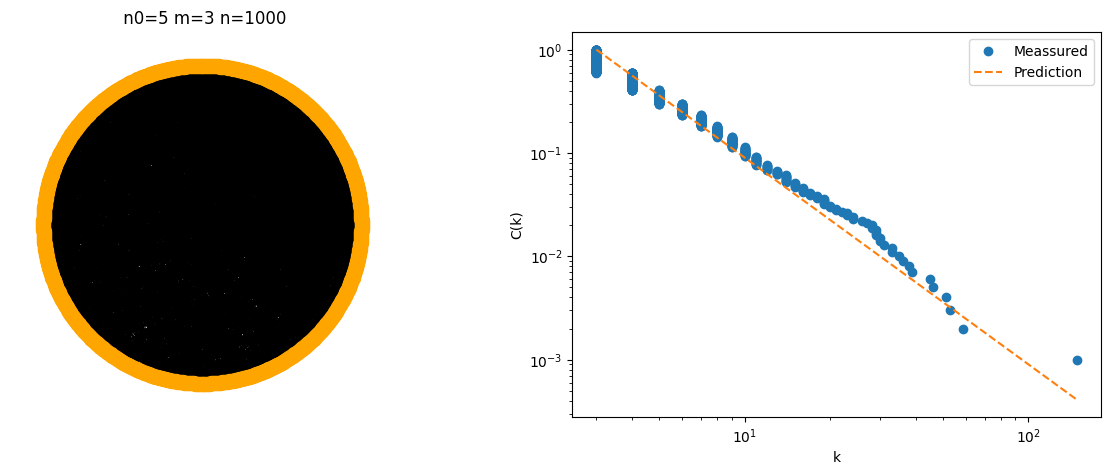

In [327]:
#CreatErdosRenyiGraph(n0,p,cN,m,nEnd)
CreatErdosRenyiGraph(3,m=1,nEnd=100)
CreatErdosRenyiGraph(3,m=3,nEnd=100)
CreatErdosRenyiGraph(10,m=1,nEnd=100)
CreatErdosRenyiGraph(10,m=10,nEnd=100)
CreatErdosRenyiGraph(5,m=3,nEnd=1000)



This shows the probability that a node has a higher degree than k as a function of k

12.4

Every node do not have a connection
Every node do not have a connection
Every node do not have a connection


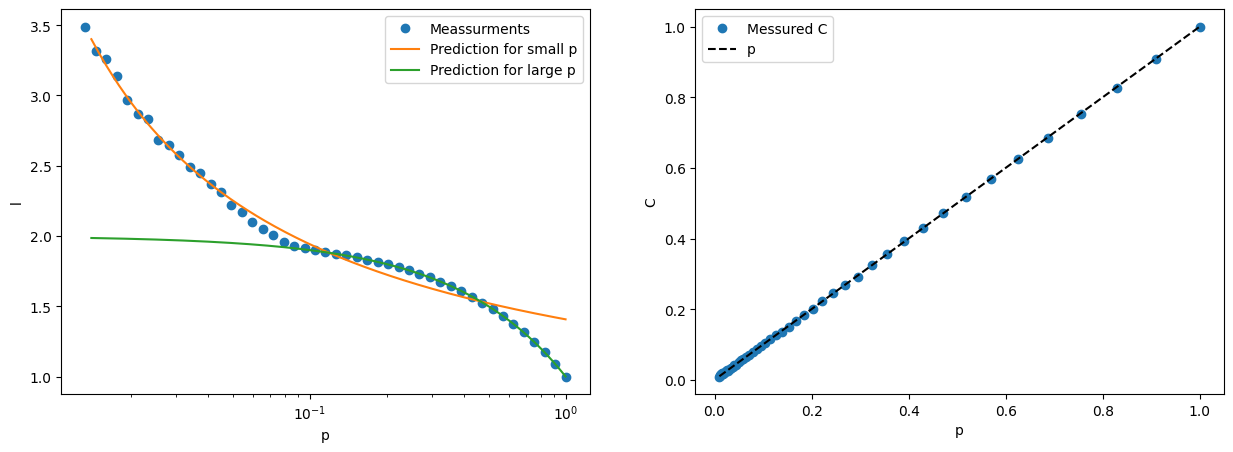

In [307]:
n=500
ps=np.logspace(-2,0,num=50,base=10)
PlotAvgLAndC(n,ps)


12.5

Every node do not have a connection


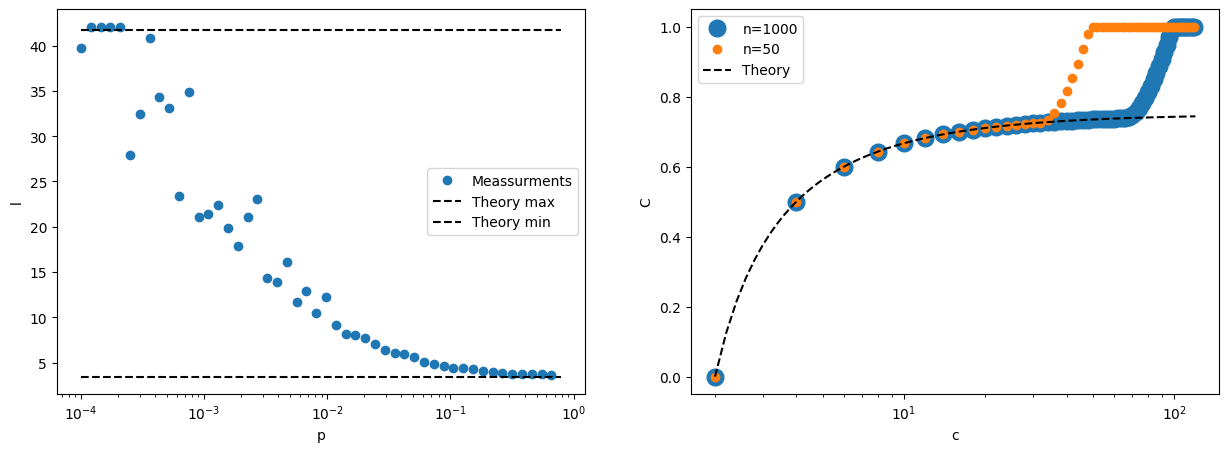

In [328]:
n=500
ps=np.logspace(-4,-0.1,num=50,base=10)
PlotAvgLAndC(n,ps,c=6)

12.6

Creating Adjency matrix for m=1


100%|██████████| 990/990 [36:48<00:00,  2.23s/it]


Creating Adjency matrix for m=3


100%|██████████| 990/990 [15:24<00:00,  1.07it/s] 


Creating Adjency matrix for m=10


100%|██████████| 980/980 [00:00<00:00, 1108.58it/s]


Calculating cluster coefficients...


100%|██████████| 980/980 [00:01<00:00, 974.41it/s] 


Calculating cluster coefficients...


100%|██████████| 980/980 [00:00<00:00, 991.61it/s] 


Calculating cluster coefficients...


100%|██████████| 980/980 [00:01<00:00, 969.36it/s] 


Calculating cluster coefficients...


100%|██████████| 980/980 [00:00<00:00, 988.30it/s] 


Calculating cluster coefficients...


100%|██████████| 980/980 [00:01<00:00, 961.55it/s] 


Calculating cluster coefficients...


100%|██████████| 980/980 [00:00<00:00, 980.44it/s] 


Calculating cluster coefficients...


100%|██████████| 980/980 [00:00<00:00, 995.90it/s] 


Calculating cluster coefficients...


100%|██████████| 980/980 [00:00<00:00, 982.16it/s] 


Calculating cluster coefficients...


100%|██████████| 980/980 [00:01<00:00, 958.07it/s] 


Calculating cluster coefficients...


100%|██████████| 980/980 [00:01<00:00, 951.83it/s] 


Calculating cluster coefficients...


100%|██████████| 980/980 [00:01<00:00, 963.89it/s] 


Calculating cluster coefficients...


100%|██████████| 980/980 [00:01<00:00, 937.57it/s] 


Calculating cluster coefficients...


100%|██████████| 980/980 [00:00<00:00, 1012.42it/s]


Calculating cluster coefficients...


100%|██████████| 980/980 [00:01<00:00, 975.64it/s] 


Calculating cluster coefficients...


100%|██████████| 980/980 [00:01<00:00, 941.44it/s] 


Calculating cluster coefficients...


100%|██████████| 980/980 [00:01<00:00, 955.84it/s] 


Calculating cluster coefficients...


100%|██████████| 980/980 [00:01<00:00, 969.32it/s] 


Calculating cluster coefficients...


100%|██████████| 980/980 [00:00<00:00, 987.26it/s] 


Calculating cluster coefficients...


100%|██████████| 980/980 [00:01<00:00, 967.12it/s] 


Calculating cluster coefficients...


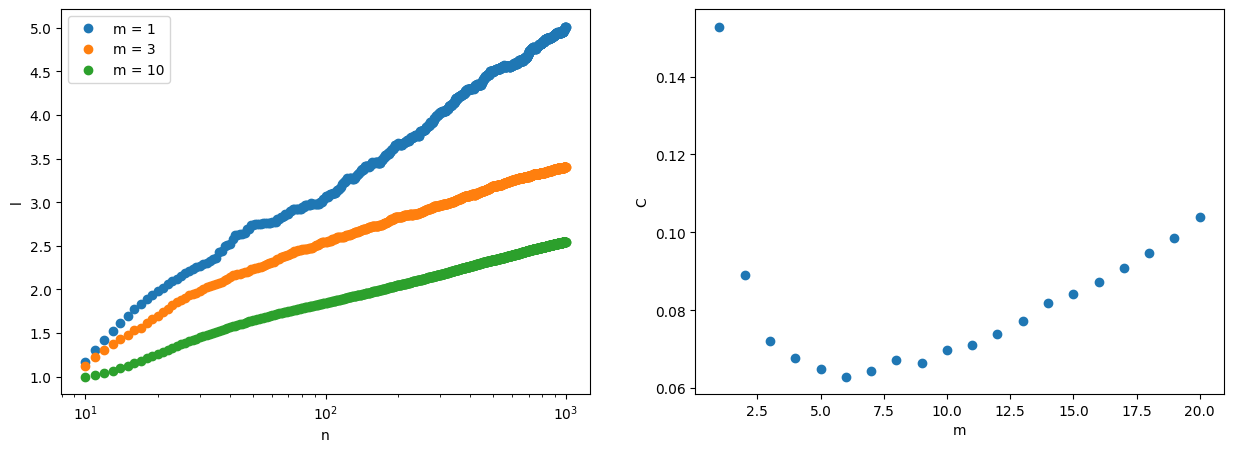

In [341]:
n0=10
nEnd=1000
print("Creating Adjency matrix for m=1")
A,lList1=CreateDataToAdjencyGraphAlbert(n0,m=1,nEnd=nEnd)
print("Creating Adjency matrix for m=3")
A,lList3=CreateDataToAdjencyGraphAlbert(n0,m=3,nEnd=nEnd)
print("Creating Adjency matrix for m=10")
A,lList10=CreateDataToAdjencyGraphAlbert(n0,m=10,nEnd=nEnd)
nList=np.arange(n0,nEnd)

fig1, (ax1,ax2) = plt.subplots(1,2,figsize=(15,5))
ax1.set_xscale("log")
ax1.plot(nList,lList1,'o',label="m = 1")
ax1.plot(nList,lList3,'o',label="m = 3")
ax1.plot(nList,lList10,'o',label="m = 10")
ax1.set_xlabel('n')
ax1.set_ylabel('l')
ax1.legend()

ms=np.arange(1,20+1)
C=[]
for m in ms:
    C.append(ClusteringCoefficantAlbert(20,c=np.NaN,m=m,nEnd=1000))

ax2.plot(ms,C,'o',label="m = 1")
ax2.set_xlabel('m')
ax2.set_ylabel('C')
plt.show()